In [179]:
import pandas as pd
import re
import numpy as np

In [180]:
def clean_value(x):
    if pd.isna(x):
        return None
    x = str(x)

    # 1) Take only first part if "69;23" → "69"
    if ";" in x:
        x = x.split(";")[0]

    # 2) Replace comma decimal → dot (16,52 → 16.52)
    x = x.replace(",", ".")

    # 3) Remove spaces
    x = x.strip()

    # 4) Convert to numeric
    try:
        return float(x)
    except:
        return None


In [181]:
def clean_value(x):
    """'30,87' / '235' / '69;23' gibi değerleri float'a çevirir."""
    if pd.isna(x):
        return None
    x = str(x)
    # "69;23" → "69"
    if ";" in x:
        x = x.split(";")[0]
    # 30,87 → 30.87
    x = x.replace(",", ".").strip()
    try:
        return float(x)
    except:
        return None


In [182]:
def clean_annual_temperature(path, country_name):
    import pandas as pd

    df = pd.read_excel(path, header=None)

    # First column is Year — we keep only numeric rows (1950, 1951, ...)
    df = df[df[0].astype(str).str.isnumeric()]

    # Rename columns
    df.columns = ["Year", "temp_raw"]

    # Convert European decimal comma: 24,24 → 24.24
    df["temp_raw"] = df["temp_raw"].astype(str).str.replace(",", ".")

    # Convert to float
    df["avg_temp"] = df["temp_raw"].astype(float)

    # Build date: first day of each year
    df["date"] = pd.to_datetime(df["Year"].astype(int), format="%Y")

    df["country"] = country_name

    return df[["date", "country", "avg_temp"]]


In [183]:
# 1) FAOSTAT Excel dosyasını oku
coffee_raw = pd.read_excel(r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\FAOSTAT_coffee.xlsx")

# 2) Kullanacağımız ülkeler
target_countries = ["Brazil", "Colombia", "Indonesia"]

# 3) Sadece Coffee, green + Production satırlarını al
coffee = coffee_raw[
    (coffee_raw["Item"] == "Coffee, green") &
    (coffee_raw["Element"] == "Production") &
    (coffee_raw["Area"].isin(target_countries))
]

# 4) Year → datetime
coffee["date"] = pd.to_datetime(coffee["Year"].astype(int), format="%Y")

# 5) Kolon isimlerini düzenle
coffee.rename(columns={"Area": "country", "Value": "production_tons"}, inplace=True)

# 6) Yıllık tidy tablo
coffee_yearly = coffee[["date", "country", "production_tons"]]

# 7) Yıllık → aylık panel
coffee_monthly = (
    coffee_yearly
    .set_index("date")
    .groupby("country")["production_tons"]
    .resample("ME")
    .ffill()
    .reset_index()
)

print(coffee_monthly.head())


  country       date  production_tons
0  Brazil 1961-01-31        2228704.0
1  Brazil 1961-02-28        2228704.0
2  Brazil 1961-03-31        2228704.0
3  Brazil 1961-04-30        2228704.0
4  Brazil 1961-05-31        2228704.0


In [184]:
stores = pd.read_csv(r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\directory.csv")


target_codes = {"BR": "Brazil", "CO": "Colombia", "ID": "Indonesia"}


stores_filtered = stores[stores["Country"].isin(target_codes.keys())].copy()


stores_filtered["country"] = stores_filtered["Country"].map(target_codes)


store_counts = stores_filtered.groupby("country").size().reset_index(name="store_count")

print(store_counts)


     country  store_count
0     Brazil          102
1   Colombia           11
2  Indonesia          268


In [185]:

store_counts = pd.DataFrame({
    "country": ["Brazil", "Colombia", "Indonesia"],
    "store_count": [102, 11, 268]
})


date_range = pd.date_range("2010-01-01", "2023-12-01", freq="MS")

df_list = []
for _, row in store_counts.iterrows():
    df = pd.DataFrame({
        "date": date_range,
        "country": row["country"],
        "store_count": row["store_count"]
    })
    df_list.append(df)

stores_monthly = pd.concat(df_list, ignore_index=True)

stores_monthly


,date,country,store_count
0,2010-01-01,Brazil,102
1,2010-02-01,Brazil,102
2,2010-03-01,Brazil,102
3,2010-04-01,Brazil,102
4,2010-05-01,Brazil,102
...,...,...,...
499,2023-08-01,Indonesia,268
500,2023-09-01,Indonesia,268
501,2023-10-01,Indonesia,268
502,2023-11-01,Indonesia,268


In [186]:
df = pd.read_excel(r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\coffee_prices_indonesia.xlsx")

# 2) Rename columns properly
df = df.rename(columns={
    "observation_date": "date",
    "PCOFFROBUSDM": "coffee_price"
})

# 3) Convert date column
df["date"] = pd.to_datetime(df["date"])

df = df[df["date"].dt.year >= 2000]
# 4) Add country
df["country"] = "Indonesia"

# 5) Keep only needed columns
indonesia_price = df[["date", "country", "coffee_price"]]

# 6) Preview
print(indonesia_price.head())
print(indonesia_price.tail())

          date    country  coffee_price
120 2000-01-01  Indonesia     54.068571
121 2000-02-01  Indonesia     48.987143
122 2000-03-01  Indonesia     46.255217
123 2000-04-01  Indonesia     44.561000
124 2000-05-01  Indonesia     43.742174
          date    country  coffee_price
421 2025-02-01  Indonesia    263.045000
422 2025-03-01  Indonesia    257.684286
423 2025-04-01  Indonesia    246.549091
424 2025-05-01  Indonesia    237.303182
425 2025-06-01  Indonesia    196.213810


In [187]:
col_raw = pd.read_excel(r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\coffee_prices_colombia.xlsx")

# 2) Kolon isimlerini düzenle
col_raw = col_raw.rename(columns={
    "Año": "year",
    "Precio externo": "coffee_price"
})

# 3) 2000 ve sonrası
col_raw = col_raw[col_raw["year"] >= 2000]

# 4) Yılı datetime'a çevir (yıllık)
col_raw["date"] = pd.to_datetime(col_raw["year"].astype(int), format="%Y")

# 5) Ülke ekle
col_raw["country"] = "Colombia"

# 6) Yıllık → aylık forward-fill
col_price_monthly = (
    col_raw[["date", "country", "coffee_price"]]
    .set_index("date")
    .groupby("country")["coffee_price"]
    .resample("ME")
    .ffill()
    .reset_index()
)

print(col_price_monthly.head())


    country       date  coffee_price
0  Colombia 2000-01-31    102.290833
1  Colombia 2000-02-29    102.290833
2  Colombia 2000-03-31    102.290833
3  Colombia 2000-04-30    102.290833
4  Colombia 2000-05-31    102.290833


In [188]:
# 1) Brazil dosyasında header 4. satırda, o yüzden:
bra_raw = pd.read_excel(r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\coffee_prices_brazil.xlsx", header=3)

# 2) Kolon isimlerini düzenle
bra_raw = bra_raw.rename(columns={
    "Date": "date",
    "Price US$": "coffee_price"
})

# 3) Tarihi datetime'a çevir
# 09/02/1996 formatı büyük ihtimalle mm/dd/yyyy → dayfirst=False
bra_raw["date"] = pd.to_datetime(bra_raw["date"], dayfirst=False, errors="coerce")

# 4) Tarihi okunamayan satırları at
bra_raw = bra_raw.dropna(subset=["date"])

# 5) 2000 ve sonrası
bra_raw = bra_raw[bra_raw["date"].dt.year >= 2000]

# 6) Ülke ekle
bra_raw["country"] = "Brazil"

# 7) Günlük → aylık ortalama fiyat
bra_price_monthly = (
    bra_raw
    .set_index("date")
    .groupby("country")["coffee_price"]
    .resample("ME")
    .mean()
    .reset_index()
)

print(bra_price_monthly.head())


  country       date  coffee_price
0  Brazil 2000-01-31    123.809524
1  Brazil 2000-02-29    111.148571
2  Brazil 2000-03-31    111.482381
3  Brazil 2000-04-30    101.897895
4  Brazil 2000-05-31     98.093182


In [189]:
prices_all = pd.concat(
    [bra_price_monthly, col_price_monthly, indonesia_price],
    ignore_index=True
)

print(prices_all.head())
print(prices_all["country"].value_counts())

  country       date  coffee_price
0  Brazil 2000-01-31    123.809524
1  Brazil 2000-02-29    111.148571
2  Brazil 2000-03-31    111.482381
3  Brazil 2000-04-30    101.897895
4  Brazil 2000-05-31     98.093182
country
Brazil       311
Indonesia    306
Colombia     289
Name: count, dtype: int64


In [190]:
# Fill store_count NA by country constant values
store_values = {
    "Brazil": 102,
    "Colombia": 11,
    "Indonesia": 268
}

panel["store_count"] = panel.apply(
    lambda row: store_values[row["country"]] if pd.isna(row["store_count"]) else row["store_count"],
    axis=1
)
panel

ValueError: Columns must be same length as key

In [ ]:
import pandas as pd

def expand_annual_to_monthly(path, country_name):
    # Read file
    df = pd.read_excel(path, header=None)

    # Find numeric year rows
    df = df[df[0].astype(str).str.isnumeric()]
    df.columns = ["Year", "temp_raw"]

    # Fix decimal commas (24,24 → 24.24)
    df["temp_raw"] = df["temp_raw"].astype(str).str.replace(",", ".")
    df["avg_temp"] = df["temp_raw"].astype(float)

    # Keep only necessary years
    df = df[(df["Year"] >= 2010) & (df["Year"] <= 2023)]

    # Expand each year into 12 months
    expanded = []
    for _, row in df.iterrows():
        year = int(row["Year"])
        avg_temp = row["avg_temp"]

        dates = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-01", freq="MS")

        for d in dates:
            expanded.append([d, country_name, avg_temp])

    expanded_df = pd.DataFrame(expanded, columns=["date", "country", "avg_temp"])
    return expanded_df


In [ ]:
brazil_temp = expand_annual_to_monthly(
    r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\brazil_weather.xlsx","Brazil")
indonesia_temp = expand_annual_to_monthly(
    r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\indonesia_weather.xlsx","Indonesia")
colombia_temp = expand_annual_to_monthly(r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\colombia_weather.xlsx","Colombia")

In [ ]:
import pandas as pd

def load_faostat_single_file(path):
    df = pd.read_excel(path)

    # We only need production quantity rows
    df = df[df["Element"] == "Production Quantity"]

    # Keep needed columns
    df = df[["Area", "Year", "Value"]]

    df = df.rename(columns={
        "Area": "country",
        "Value": "production_tons"
    })

    # Convert year → datetime
    df["date"] = pd.to_datetime(df["Year"].astype(int), format="%Y")

    # Select final structure
    df = df[["date", "country", "production_tons"]]

    return df


In [ ]:
production = load_faostat_single_file(r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\FAOSTAT_coffee.xlsx")


In [ ]:
def expand_production_to_months(df):
    rows = []
    for _, row in df.iterrows():
        year = row["date"].year
        prod = row["production_tons"]
        country = row["country"]

        # Create monthly dates
        months = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-01", freq="MS")

        for d in months:
            rows.append([d, country, prod])

    return pd.DataFrame(rows, columns=["date", "country", "production_tons"])


In [ ]:
production_monthly = expand_production_to_months(production)


In [ ]:
production["date"] = pd.to_datetime(production["date"]).values.astype("datetime64[M]")
production_2010 = production[production["date"] >= "2010-01-01"]



In [ ]:
prices_all["date"] = pd.to_datetime(prices_all["date"]).values.astype("datetime64[M]")
prices_2010 = prices_all[prices_all["date"] >= "2010-01-01"]


In [ ]:
import pandas as pd

# ------------ LOAD FAOSTAT -------------
def load_faostat_single_file(path):
    df = pd.read_excel(path)

    # Keep production only
    df = df[df["Element"] == "Production Quantity"]

    # Keep needed columns
    df = df[["Area", "Year", "Value"]]
    df = df.rename(columns={
        "Area": "country",
        "Value": "production_tons"
    })

    # Convert year → datetime
    df["date"] = pd.to_datetime(df["Year"].astype(int), format="%Y")

    return df[["date", "country", "production_tons"]]

production = load_faostat_single_file(r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\FAOSTAT_coffee.xlsx")


In [ ]:
production_monthly = expand_production_to_months(production)
production_monthly = production_monthly[production_monthly["date"] >= "2010-01-01"]
prices_all["date"] = pd.to_datetime(prices_all["date"]).values.astype("datetime64[M]")
prices_2010 = prices_all[prices_all["date"] >= "2010-01-01"]


In [215]:
# 1) FAOSTAT dosyasını oku
faostat = pd.read_excel(r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\FAOSTAT_coffee.xlsx")

# 2) Sadece Coffee, green + Production satırlarını seç
faostat_clean = faostat[
    (faostat["Item"] == "Coffee, green") &
    (faostat["Element"] == "Production")
].copy()

# 3) Kolonları sadeleştir
faostat_clean = faostat_clean.rename(columns={
    "Area": "country",
    "Year": "Year",
    "Value": "production_tons"
})

# 4) Sadece ihtiyacımız olan kolonları al
faostat_clean = faostat_clean[["country", "Year", "production_tons"]]

# 5) 2010 sonrası filtre
faostat_clean = faostat_clean[faostat_clean["Year"] >= 2010]

# 6) Tarih kolonunu oluştur (yıllık)
faostat_clean["date"] = pd.to_datetime(faostat_clean["Year"].astype(str) + "-01-01")

# 7) Son üretim dataset'i
production_yearly = faostat_clean[["date", "country", "production_tons"]].reset_index(drop=True)

production_yearly.head()


,date,country,production_tons
0,2010-01-01,Brazil,2907265.0
1,2011-01-01,Brazil,2700540.0
2,2012-01-01,Brazil,3037534.0
3,2013-01-01,Brazil,2964538.0
4,2014-01-01,Brazil,2804070.0


In [216]:
def expand_annual_to_monthly(path, country_name):
    df = pd.read_excel(path, header=None)

    # keep only numeric Year rows
    df = df[df[0].astype(str).str.isnumeric()]
    df.columns = ["Year", "temp_raw"]

    # clean decimal commas
    df["temp_raw"] = df["temp_raw"].astype(str).str.replace(",", ".")
    df["avg_temp"] = df["temp_raw"].astype(float)

    # filter 2010–2023
    df = df[(df["Year"] >= 2010) & (df["Year"] <= 2023)]

    # expand to monthly
    rows = []
    for _, row in df.iterrows():
        year = int(row["Year"])
        temp = row["avg_temp"]

        months = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-01", freq="MS")
        for d in months:
            rows.append([d, country_name, temp])

    return pd.DataFrame(rows, columns=["date", "country", "avg_temp"])
brazil_temp = expand_annual_to_monthly(r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\brazil_weather.xlsx", "Brazil")
colombia_temp = expand_annual_to_monthly(r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\colombia_weather.xlsx", "Colombia")
indonesia_temp = expand_annual_to_monthly(r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\indonesia_weather.xlsx", "Indonesia")

climate_temp = pd.concat([brazil_temp, colombia_temp, indonesia_temp], ignore_index=True)


In [217]:
store_months = pd.date_range("2010-01-01", "2023-12-01", freq="MS")

stores_raw = pd.DataFrame({
    "country": ["Brazil", "Colombia", "Indonesia"],
    "store_count": [102, 11, 268]
})

rows = []
for _, row in stores_raw.iterrows():
    for d in store_months:
        rows.append([d, row["country"], row["store_count"]])

stores_2010 = pd.DataFrame(rows, columns=["date", "country", "store_count"])


In [222]:
print("BRAZIL:", brazil_price.columns)
print("COLOMBIA:", colombia_price.columns)
print("INDONESIA:", indonesia_price.columns)


BRAZIL: Index(['Unnamed: 0', 'Unnamed: 1', 'country'], dtype='object')
COLOMBIA: Index(['Año', 'Precio externo', 'country'], dtype='object')
INDONESIA: Index(['observation_date', 'PCOFFROBUSDM', 'country'], dtype='object')


In [218]:
panel = (
    production_monthly
    .merge(prices_2010, on=["date","country"], how="left")
    .merge(climate_temp, on=["date","country"], how="left")
    .merge(stores_2010, on=["date","country"], how="left")
)

panel = panel.sort_values(["country","date"]).reset_index(drop=True)


In [226]:
# Load raw data
brazil_raw = pd.read_excel(
    r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\coffee_prices_brazil.xlsx",
    header=None
)

# Drop the first two empty rows
brazil_raw = brazil_raw.iloc[2:].reset_index(drop=True)

# Set the column names based on the third row
brazil_raw.columns = ["date", "coffee_price"]

# Remove the old header row ("Date", "Price US$")
brazil_raw = brazil_raw[brazil_raw["date"] != "Date"]

# Drop rows where date is NaN or price is NaN
brazil_raw = brazil_raw.dropna()

# Convert date to datetime
brazil_raw["date"] = pd.to_datetime(brazil_raw["date"], errors="coerce")

# Remove rows where date conversion failed
brazil_raw = brazil_raw.dropna(subset=["date"])

# Convert price: replace commas with dots, then convert to float
brazil_raw["coffee_price"] = (
    brazil_raw["coffee_price"]
    .astype(str)
    .str.replace(",", ".", regex=False)
)

# Remove any non-numeric strings remaining
brazil_raw = brazil_raw[brazil_raw["coffee_price"].str.match(r"^\d+(\.\d+)?$")]

brazil_raw["coffee_price"] = brazil_raw["coffee_price"].astype(float)

# Add country column
brazil_raw["country"] = "Brazil"

# Extract year
brazil_raw["Year"] = brazil_raw["date"].dt.year

# Keep 2010+
brazil_price = brazil_raw[brazil_raw["Year"] >= 2010]

# Compute annual average
brazil_price_yearly = (
    brazil_price.groupby(["Year", "country"])["coffee_price"]
    .mean()
    .reset_index()
)

# Build date column
brazil_price_yearly["date"] = pd.to_datetime(
    brazil_price_yearly["Year"].astype(str) + "-01-01"
)

brazil_price_yearly.head()


,Year,country,coffee_price,date
0,2010,Brazil,177.195341,2010-01-01
1,2011,Brazil,296.379520,2011-01-01
2,2012,Brazil,201.761245,2012-01-01
3,2013,Brazil,134.784661,2013-01-01
4,2014,Brazil,177.974502,2014-01-01


In [229]:
# Load Colombia file
col_raw = pd.read_excel(
    r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\coffee_prices_colombia.xlsx"
)

# Rename columns
col_raw = col_raw.rename(columns={
    "Año": "Year",
    "Precio externo": "coffee_price"
})

# Add country name
col_raw["country"] = "Colombia"

# Remove rows where year or price is NaN
col_raw = col_raw.dropna(subset=["Year", "coffee_price"])

# Convert Year to int
col_raw["Year"] = col_raw["Year"].astype(int)

# Convert price to numeric (comma → dot)
col_raw["coffee_price"] = (
    col_raw["coffee_price"].astype(str)
    .str.replace(",", ".", regex=False)
    .astype(float)
)

# Filter for 2010+
col_price_yearly = col_raw[col_raw["Year"] >= 2010].copy()

# Add date column
col_price_yearly["date"] = pd.to_datetime(
    col_price_yearly["Year"].astype(str) + "-01-01"
)

col_price_yearly = col_price_yearly[["date", "Year", "country", "coffee_price"]]

col_price_yearly.head()


,date,Year,country,coffee_price
97,2010-01-01,2010,Colombia,224.593151
98,2011-01-01,2011,Colombia,284.308555
99,2012-01-01,2012,Colombia,203.187953
100,2013-01-01,2013,Colombia,148.426164
101,2014-01-01,2014,Colombia,197.072827


In [228]:
# Load Indonesia file
indo_raw = pd.read_excel(
    r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\coffee_prices_indonesia.xlsx"
)

# Clean columns
indo_raw = indo_raw.rename(columns={
    "observation_date": "date",
    "PCOFFROBUSDM": "coffee_price"
})

indo_raw["country"] = "Indonesia"

# Convert date to datetime
indo_raw["date"] = pd.to_datetime(indo_raw["date"], errors="coerce")

# Remove invalid rows
indo_raw = indo_raw.dropna(subset=["date", "coffee_price"])

# Extract year
indo_raw["Year"] = indo_raw["date"].dt.year

# Filter for 2010+
indo_raw = indo_raw[indo_raw["Year"] >= 2010]

# Convert price to float
indo_raw["coffee_price"] = indo_raw["coffee_price"].astype(float)

# Compute annual average
indo_price_yearly = (
    indo_raw.groupby(["Year", "country"])["coffee_price"]
    .mean()
    .reset_index()
)

# Add date column
indo_price_yearly["date"] = pd.to_datetime(
    indo_price_yearly["Year"].astype(str) + "-01-01"
)

indo_price_yearly = indo_price_yearly[["date", "Year", "country", "coffee_price"]]

indo_price_yearly.head()


,date,Year,country,coffee_price
0,2010-01-01,2010,Indonesia,78.731030
1,2011-01-01,2011,Indonesia,109.238366
2,2012-01-01,2012,Indonesia,102.843509
3,2013-01-01,2013,Indonesia,94.117763
4,2014-01-01,2014,Indonesia,100.419395


In [230]:
prices_yearly = pd.concat(
    [brazil_price_yearly, col_price_yearly, indo_price_yearly],
    ignore_index=True
)

prices_yearly.head()


,Year,country,coffee_price,date
0,2010,Brazil,177.195341,2010-01-01
1,2011,Brazil,296.379520,2011-01-01
2,2012,Brazil,201.761245,2012-01-01
3,2013,Brazil,134.784661,2013-01-01
4,2014,Brazil,177.974502,2014-01-01


In [231]:
# Define store numbers
stores_raw = pd.DataFrame({
    "country": ["Brazil", "Colombia", "Indonesia"],
    "store_count": [102, 11, 268]
})

# Create yearly date range
years = list(range(2010, 2024))  # 2010–2023

# Expand to yearly panel
store_rows = []
for _, row in stores_raw.iterrows():
    for y in years:
        store_rows.append([
            pd.to_datetime(f"{y}-01-01"),
            y,
            row["country"],
            row["store_count"]
        ])

store_count_yearly = pd.DataFrame(
    store_rows,
    columns=["date", "Year", "country", "store_count"]
)

store_count_yearly.head(), store_count_yearly.tail()


(        date  Year country  store_count
 0 2010-01-01  2010  Brazil          102
 1 2011-01-01  2011  Brazil          102
 2 2012-01-01  2012  Brazil          102
 3 2013-01-01  2013  Brazil          102
 4 2014-01-01  2014  Brazil          102,
          date  Year    country  store_count
 37 2019-01-01  2019  Indonesia          268
 38 2020-01-01  2020  Indonesia          268
 39 2021-01-01  2021  Indonesia          268
 40 2022-01-01  2022  Indonesia          268
 41 2023-01-01  2023  Indonesia          268)

In [232]:
# Merge production + prices
panel_yearly = production_yearly.merge(
    prices_yearly,
    on=["Year", "country"],
    how="left"
)

# Merge store count
panel_yearly = panel_yearly.merge(
    store_count_yearly[["Year", "country", "store_count"]],
    on=["Year", "country"],
    how="left"
)

panel_yearly.head()


KeyError: 'Year'

In [219]:
summary_by_country = (
    panel.groupby("country")[["production_tons", "coffee_price", "avg_temp", "store_count"]]
         .mean()
         .round(2)
)
print(summary_by_country)



Empty DataFrame
Columns: [production_tons, coffee_price, avg_temp, store_count]
Index: []


In [220]:
panel["date"] = pd.to_datetime(panel["date"])
prices_all["date"] = pd.to_datetime(prices_all["date"])
climate_all["date"] = pd.to_datetime(climate_all["date"])
stores_monthly["date"] = pd.to_datetime(stores_monthly["date"])


In [200]:
panel["date"] = panel["date"].dt.to_period("M").dt.to_timestamp()
prices_all["date"] = prices_all["date"].dt.to_period("M").dt.to_timestamp()
climate_all["date"] = climate_all["date"].dt.to_period("M").dt.to_timestamp()
stores_monthly["date"] = stores_monthly["date"].dt.to_period("M").dt.to_timestamp()


In [203]:
panel.info()
panel.isna().sum()
panel.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             0 non-null      datetime64[ns]
 1   country          0 non-null      object        
 2   production_tons  0 non-null      object        
 3   coffee_price     0 non-null      float64       
 4   avg_temp         0 non-null      float64       
 5   store_count      0 non-null      int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 132.0+ bytes


,date,coffee_price,avg_temp,store_count
count,0,0.0,0.0,0.0
mean,NaT,NaN,NaN,NaN
min,NaT,NaN,NaN,NaN
25%,NaT,NaN,NaN,NaN
50%,NaT,NaN,NaN,NaN
75%,NaT,NaN,NaN,NaN
max,NaT,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN


In [201]:
import matplotlib.pyplot as plt

countries = panel["country"].unique()


C:\Users\hp\AppData\Local\Temp\ipykernel_18256\933653493.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


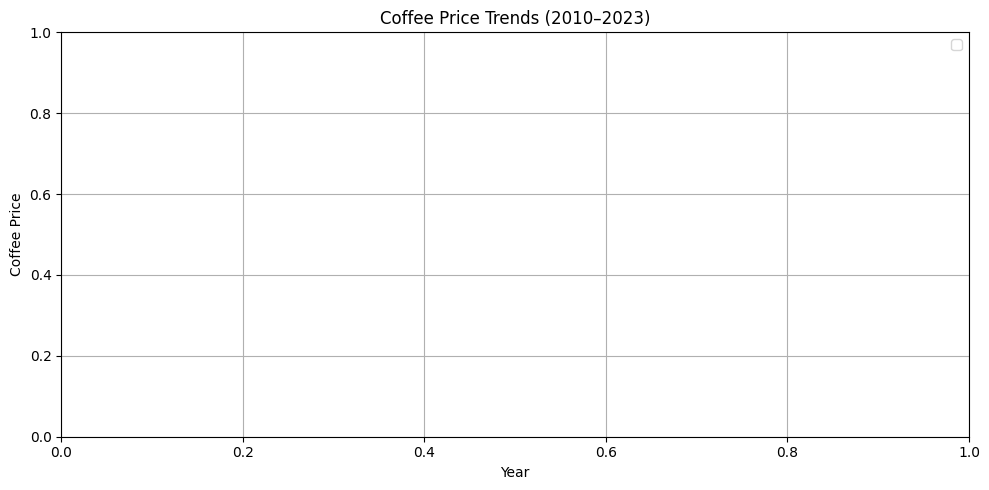

In [202]:
plt.figure(figsize=(10,5))
for c in countries:
    sub = panel[panel["country"] == c]
    plt.plot(sub["date"], sub["coffee_price"], label=c)

plt.title("Coffee Price Trends (2010–2023)")
plt.xlabel("Year")
plt.ylabel("Coffee Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_18256\1148551097.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


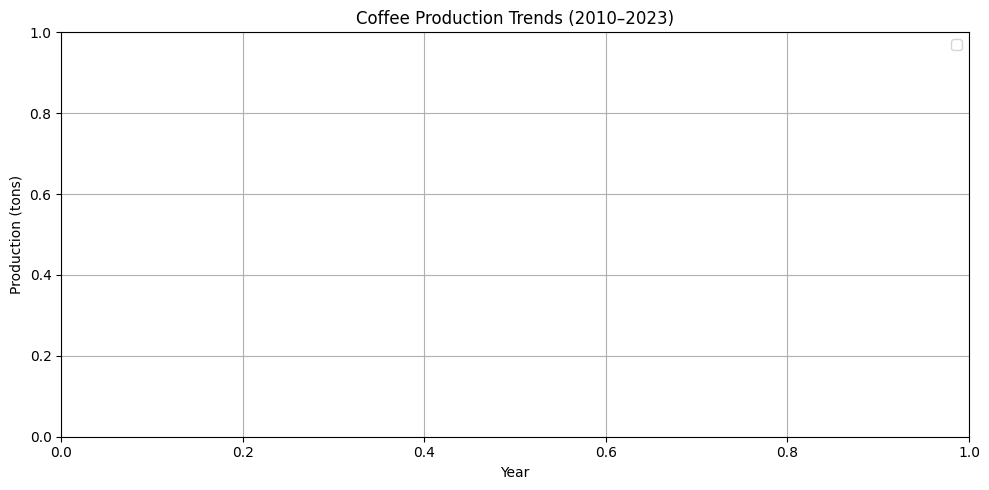

In [ ]:
plt.figure(figsize=(10,5))
for c in countries:
    sub = panel[panel["country"] == c]
    plt.plot(sub["date"], sub["production_tons"], label=c)

plt.title("Coffee Production Trends (2010–2023)")
plt.xlabel("Year")
plt.ylabel("Production (tons)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
num_cols = ["production_tons", "coffee_price", "avg_temp", "rainfall", "store_count"]
corr = panel[num_cols].corr()
corr


,production_tons,coffee_price,avg_temp,rainfall,store_count
production_tons,1.000000,0.210158,-0.027335,-0.483177,0.001638
coffee_price,0.210158,1.000000,-0.282557,-0.129893,-0.226891
avg_temp,-0.027335,-0.282557,1.000000,0.285374,0.269109
rainfall,-0.483177,-0.129893,0.285374,1.000000,0.056789
store_count,0.001638,-0.226891,0.269109,0.056789,1.000000


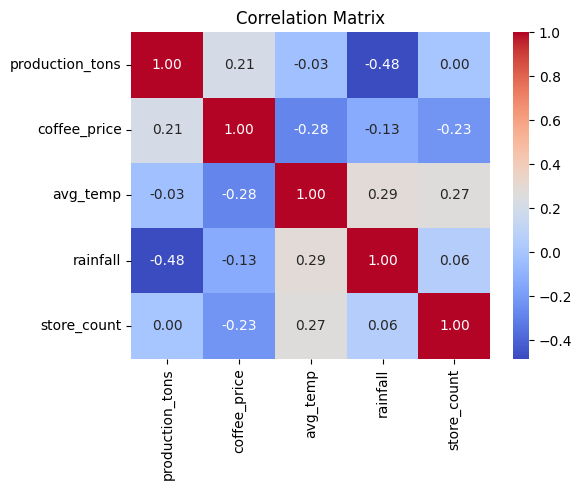

In [ ]:
import seaborn as sns
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


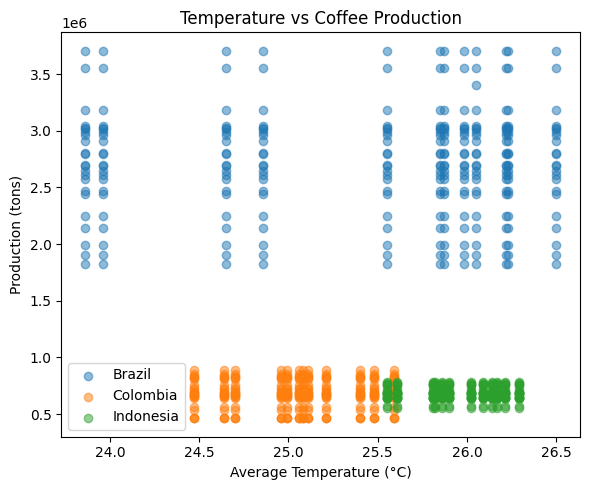

In [ ]:
plt.figure(figsize=(6,5))
for c in panel["country"].unique():
    subset = panel[panel["country"] == c]
    plt.scatter(subset["avg_temp"], subset["production_tons"], alpha=0.5, label=c)

plt.xlabel("Average Temperature (°C)")
plt.ylabel("Production (tons)")
plt.title("Temperature vs Coffee Production")
plt.legend()
plt.tight_layout()
plt.show()


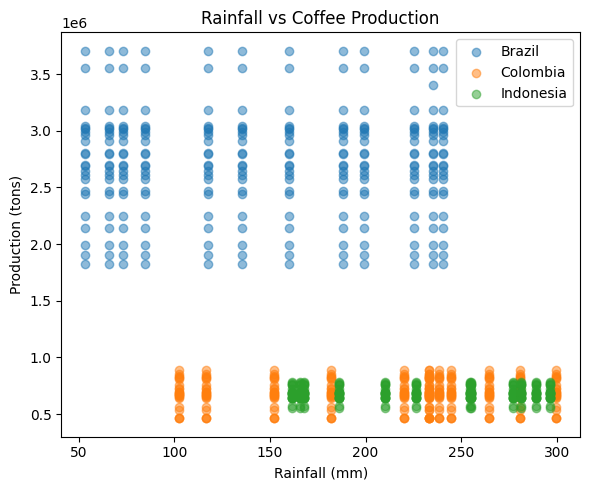

In [ ]:
plt.figure(figsize=(6,5))
for c in panel["country"].unique():
    subset = panel[panel["country"] == c]
    plt.scatter(subset["rainfall"], subset["production_tons"], alpha=0.5, label=c)

plt.xlabel("Rainfall (mm)")
plt.ylabel("Production (tons)")
plt.title("Rainfall vs Coffee Production")
plt.legend()
plt.tight_layout()
plt.show()


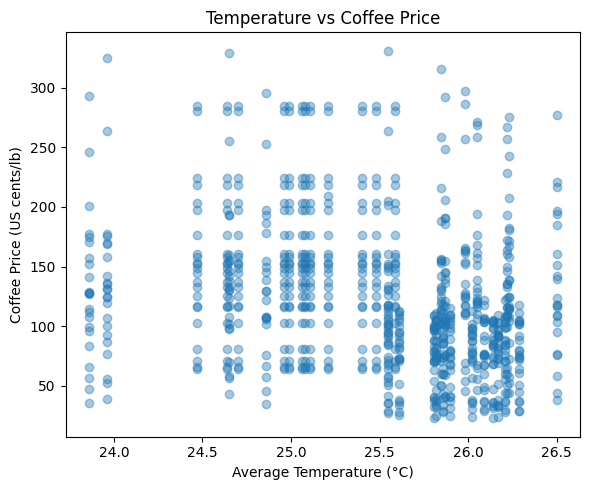

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(panel["avg_temp"], panel["coffee_price"], alpha=0.4)
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Coffee Price (US cents/lb)")
plt.title("Temperature vs Coffee Price")
plt.tight_layout()
plt.show()
